In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
from sklearn.svm import SVR, OneClassSVM, NuSVR
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import zscore, t

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import IsolationForest

from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.neighbors import LocalOutlierFactor


from sklearn.feature_selection import RFE,RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectFromModel


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OrdinalEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

In [2]:
#function returns SOC value
def get_soc(kernel,sp,p):
    if kernel=='rbf':
        return sp*(3*p+3)
    if kernel == 'linear':
        return sp*(2*p+1)
    if kernel == 'poly':
        return sp*(2*p+3+2)
    
    return sp*(2*p+12)

#custom metric based on SOC
def soc_metric(model,*args,**kwargs):
  X,y=args
  return -get_soc(model.kernel,len(model.support_vectors_),X.shape[1])

In [3]:
uploaded = 'http://archive.ics.uci.edu/ml/machine-learning-databases/servo/servo.data'
column_names = ['motor','screw','pgain','vgain','class']
df = pd.read_csv(uploaded,names=column_names)

print(df.shape)
print(df.head())
df[['motor','screw']] = OrdinalEncoder().fit_transform(df[['motor','screw']])
pd.DataFrame(data=[df.skew(),df.kurtosis()],index=['skewness','kurtosis'])

(167, 5)
  motor screw  pgain  vgain     class
0     E     E      5      4  0.281251
1     B     D      6      5  0.506252
2     D     D      4      3  0.356251
3     B     A      3      2  5.500033
4     D     B      6      5  0.356251


,motor,screw,pgain,vgain,class
skewness,0.175841,0.170644,0.549742,0.522405,1.790989
kurtosis,-1.219915,-1.314239,-0.774954,-0.968469,2.072995


In [4]:
#convert categorical variables(motor and screw) into integers using OrdinalEncoder

df[['motor','screw']] = OrdinalEncoder().fit_transform(df[['motor','screw']])
columns = ['motor','screw','pgain','vgain']
#scale independent variables,
df[columns]=StandardScaler().fit_transform(df[columns])

#apply z-score outlier treatment
z = np.abs(zscore(df[['pgain']]))
df = df[ (z < 3) ]

z = np.abs(zscore(df[['vgain']]))
df = df[ (z < 3) ]

z = np.abs(zscore(df[['class']]))
df = df[ (z < 3) ]

print(df.shape)
df.head()

(165, 5)


,motor,screw,pgain,vgain,class
0,1.504301,1.524517,0.832065,1.069805,0.281251
1,-0.624667,0.826998,1.817560,1.802008,0.506252
2,0.794645,0.826998,-0.153430,0.337602,0.356251
3,-0.624667,-1.265558,-1.138926,-0.394600,5.500033
4,0.794645,-0.568039,1.817560,1.802008,0.356251


In [5]:
columns = ['motor','screw','pgain','vgain']

X_orig=df[columns]
y=df['class']

print(X_orig.shape)

(165, 4)


In [6]:
#remove outliers using n_neighbors=20 (default value)
outliers = LocalOutlierFactor(n_neighbors=20).fit_predict(X_orig)
target_out = LocalOutlierFactor(n_neighbors=20).fit_predict(y.values.reshape(-1, 1))
outliers = outliers == 1
target_out = target_out == 1
for i,t in enumerate(target_out):
  outliers[i]=outliers[i] and t

X_orig,y=X_orig[outliers],y[outliers]
X_orig.shape

(152, 4)

In [7]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_orig.values, i) for i in range(X_orig.shape[1])]
vif["features"] = pd.Index(X_orig.columns)
vif

,VIF Factor,features
0,1.002871,motor
1,1.069808,screw
2,3.155504,pgain
3,3.079987,vgain


There are no variable with VIF>=10

In [8]:
# ['motor','screw','pgain','vgain']
# X=X_orig.drop(['screw'],axis=1)
# X.head()
X=X_orig[:]
# X = SelectKBest(f_regression, k=3).fit_transform(X_orig, y)
# print(X[:10])
# X_orig.head()

In [9]:
k=X.shape[1]
cv = KFold(n_splits=10, shuffle= True,random_state=100)
# acc_metric='neg_mean_squared_error'
acc_metric='neg_mean_absolute_error'
model_selected=None
minRMSE=np.inf
train_sizes=np.array([0.1,0.2,0.3,0.4,0.5,1.0])
X.shape

(152, 4)

In [10]:
model=LinearRegression()
mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)

MSE:  0.86327761764221 STD:  0.14128916828999974


Best Hyperparameters::
{'C': 46.41588833612773, 'gamma': 0.21544346900318823, 'kernel': 'rbf'}
# SV 79
SOC:  1185
MSE:  0.2267571049969735 STD:  0.08191326523094199


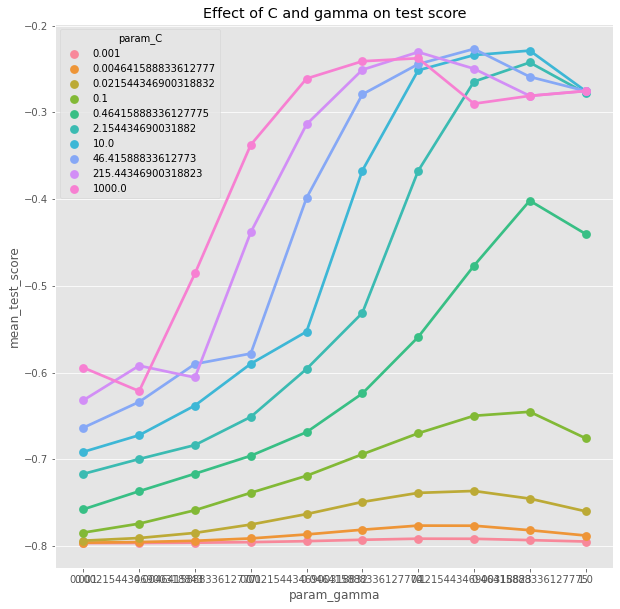

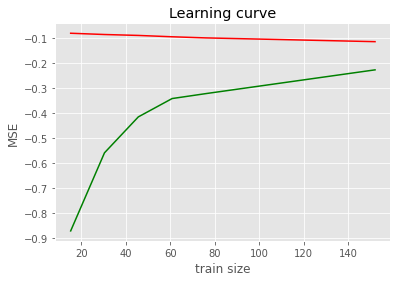

In [11]:
params = {'C':np.logspace(-3,3,10),
          'gamma':np.logspace(-3,0,10),
          'kernel':['rbf',]}



gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)

print("Best Hyperparameters::\n{}".format(gcv.best_params_))

results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(10,10))
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")

svr=gcv.best_estimator_

print("# SV",len(svr.support_vectors_))
print("SOC: ",len(svr.support_vectors_)*(3*k+3))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
    
std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()


In [12]:
minRMSE=0.2267571049969735
minRMSE,minRMSE*1.1

(0.2267571049969735, 0.24943281549667087)

In [13]:
k=X.shape[1]

gamma_range = np.logspace(-3,0,100)
C_range=np.logspace(-3,3,10)
min_soc = 1000000
min_gamma=100000
min_c = 100000
socs = np.array([])
mses=np.array([])
colors=np.array([])
min_err=100000
gammas=np.array([])
Cs=np.array([])
for C in C_range:
    for gamma in gamma_range:
        model = SVR(C=C,gamma=gamma,kernel='rbf')
        model.fit(X,y)
        soc = len(model.support_vectors_)*(3*k+3)
        
        socs = np.append(socs,soc)
        mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)
        mse=np.abs(np.mean(mse))
        mses = np.append(mses,mse)
        gammas = np.append(gammas,gamma)
        Cs = np.append(Cs,C)
        if mse > minRMSE*1.1:
            colors=np.append(colors,'red')
        else:
            colors=np.append(colors,'green')
        if min_soc >= soc:
            min_soc = soc
            min_gamma = gamma
            min_c = C
            min_err=mse

min SOC  1185  err  0.22675710499697357
min C  46.41588833612773
min gamma  0.21544346900318845


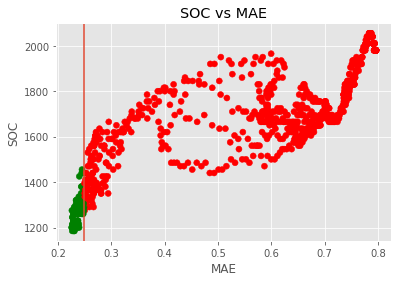

In [14]:
plt.title('SOC vs MAE')
plt.scatter(mses,socs,c=colors)
plt.xlabel('MAE')
plt.ylabel('SOC')
plt.axvline(x=minRMSE*1.1)
# for i in range(len(mses)):
#     if mses[i] <= minRMSE*1.1:
#         plt.annotate(i, (mses[i], socs[i]))
    
print('min SOC ',min_soc,' err ',min_err)
print('min C ',min_c)
print('min gamma ',min_gamma)
plt.show()

In [15]:
errors=np.asarray(mses)
socs=np.asarray(socs)
mask=socs <= 1000
print(errors[mask])
print(socs[mask])
print(gammas[mask])
print(Cs[mask])

[]
[]
[]
[]


In [16]:
1000/(3*k+3)

66.66666666666667

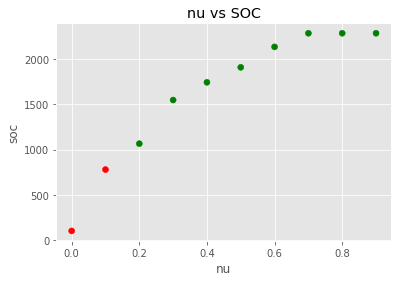

In [21]:
nu_range = np.linspace(0.0001,0.9,10)
socs = []
mses = []
nus = []

for nu in nu_range:
    model = NuSVR(nu=nu,C=46.41588833612773, gamma=0.21544346900318823, kernel='rbf')
#     model = NuSVR(nu=nu,C=1000, gamma=0.46415888336127775, kernel='rbf')
    mse = cross_val_score(model,X,y,cv=cv,scoring=acc_metric)

    std=np.std(mse)
    mse=np.abs(np.mean(mse))
    
    model.fit(X,y)

    if mse <= minRMSE * 1.1 or True:
        socs.append(model.n_support_[0]*(3*k+3))
        mses.append(mse)
        nus.append(nu)

colors = []
for mse in mses:
    if mse > minRMSE * 1.1:
        colors.append('red')
    else:
        colors.append('green')
        
plt.title("nu vs SOC")
plt.scatter(nus,socs,c=colors)
plt.xlabel('nu')
plt.ylabel('soc')
plt.show()

In [22]:
errors=np.asarray(mses)
socs=np.asarray(socs)
mask=errors <= minRMSE * 1.5
print(errors[mask])
print(socs[mask])
print(nu_range[mask])

[0.30605485 0.23794976 0.2052992  0.19062174 0.18643921 0.1850706
 0.18323318 0.18318178 0.18329004]
[ 780 1065 1545 1740 1905 2130 2280 2280 2280]
[0.10008889 0.20007778 0.30006667 0.40005556 0.50004444 0.60003333
 0.70002222 0.80001111 0.9       ]


Best Hyperparameters::
{'C': 31.578947368421055, 'kernel': 'linear'}
SOC:  868
MSE:  0.6768941012019216 STD:  0.29358135961584186


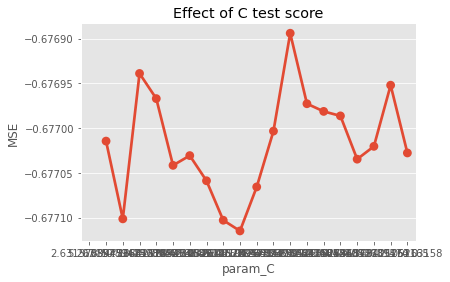

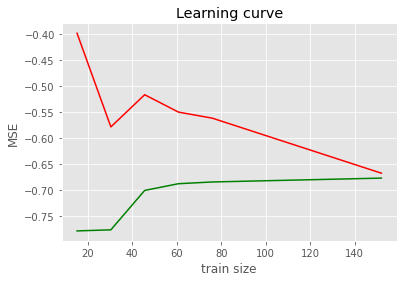

In [175]:
params = {'C':np.linspace(0,50,20),
          'kernel':['linear']}


gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=results[['mean_test_score',
                           'param_C']],
             y='mean_test_score',x='param_C')
ax.set(title="Effect of C test score")
ax.set(ylabel='MSE')


svr=gcv.best_estimator_

print("SOC: ",len(svr.support_vectors_)*(2*k+1))

mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)

std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 23.33333333333333, 'gamma': 0.004641588833612782, 'kernel': 'sigmoid'}
SOC:  1476
MSE:  0.673795260018569 STD:  0.2933521092639311


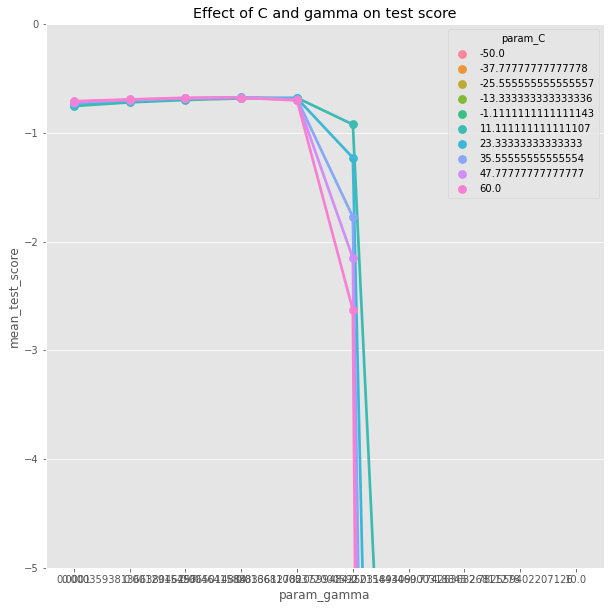

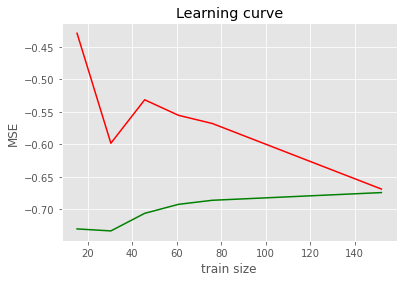

In [14]:
params = {'C':np.linspace(-50,60,10),
          'gamma':np.logspace(-4,1,10),
          'kernel':['sigmoid',]}

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots(figsize=(10,10))
ax.set_ylim([-5,0])
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+4))

mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)
std=np.std(mse)

mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

Best Hyperparameters::
{'C': 2, 'degree': 3, 'gamma': 0.1, 'kernel': 'poly'}
SOC:  1210
MSE:  0.7323421325548357 STD:  0.3151871058856129


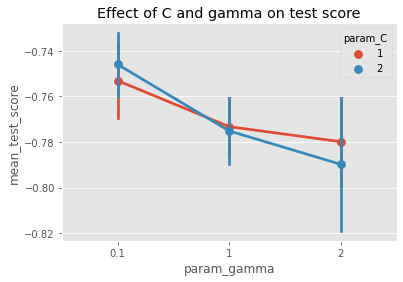

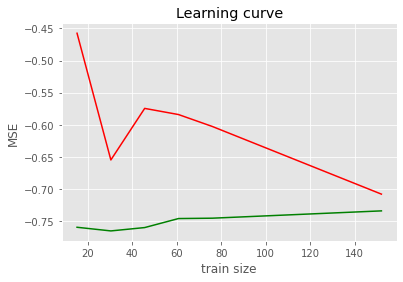

In [177]:
params = {'C':[1,2],
          'gamma':[0.1,1,2],
          'degree':[2,3],
          'kernel':['poly'],
         }

gcv = GridSearchCV(SVR(),params,cv=cv,scoring=acc_metric)
gcv.fit(X,y)
print("Best Hyperparameters::\n{}".format(gcv.best_params_))
results = pd.DataFrame(data=gcv.cv_results_)
fig,ax = plt.subplots()
sns.pointplot(data=results[['mean_test_score',
                           'param_C',
                           'param_gamma']],
             y='mean_test_score',x='param_gamma',
             hue='param_C',ax=ax)
ax.set(title="Effect of C and gamma on test score")
svr=gcv.best_estimator_
print("SOC: ",len(svr.support_vectors_)*(2*k+4))


mse = cross_val_score(svr,X,y,cv=cv,scoring=acc_metric)

std=np.std(mse)
mse=np.abs(np.mean(mse))
print("MSE: ",mse,"STD: ",std)
if mse < minRMSE:
    minRMSE=mse
    model_selected=svr
plt.show()

_,train_scores,test_scores=learning_curve(svr,X,y,cv=cv,train_sizes=train_sizes,scoring=acc_metric)
plt.title("Learning curve")
plt.plot(len(X)*train_sizes,train_scores.mean(axis=1),'r-')
plt.plot(len(X)*train_sizes,test_scores.mean(axis=1),'g-')
plt.xlabel('train size')
plt.ylabel('MSE')
plt.show()

In [ ]:
# soc=get_soc(model_selected.kernel,len(model_selected.support_vectors_),k)
# print('Best Model: ',model_selected, 'kernel: ',model_selected.kernel)
# print('SOC: ',soc)
# print('MSE: ',minRMSE)

Best Model:  SVR(C=46.41588833612773, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.21544346900318823, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False) kernel:  rbf
SOC:  1027
MSE:  0.2267886535827607


In [ ]:
# import pickle
# !git clone https://github.com/zhumakhan/IML.git
# filename='./servo+svr.model'

# with open(filename, 'wb') as file:
#     pickle.dump(model_selected,file)

# !mv ./servo+svr.model ./IML/servo+svr.model
# !cd IML && git add . && git commit -m'svr model update' && git push --force
# !rm -rf ./IML
# some time later...
# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(X_test, Y_test)
# print(result)

fatal: destination path 'IML' already exists and is not an empty directory.
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean
